In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal, uniform, choice, randint
from numpy import pi
import sys, shutil
from tqdm import tqdm
from deeptracktorch.disp import *
from deeptracktorch.simg import *
from deeptracktorch.measures import radialcenter
from deeptracktorch.models import DeepTrackNet
from deeptracktorch.video import track_single_particle

from fastai.vision import *
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Experiment 1: Extract Particle Position From Images Using segmentation
> An experiment to train NN to extract position of particle from image conatining 1 particle.

## Introduction

The aim of this notebook is to demonstrate the process of training a Neural Network to extract the position of a particle from an image.

It will only consider images containing a single particle.

The stages are as follows:
 * Generate a set of synthetic images: Training, Validation and Test Sets
 * Define a DataLoader for this training data.
 * Load our Neural Network architecture and train the network
 * Use the trained network to extract the position of particles in the test set
 * Evaluate the accuracy of the extractions
 * (consider hyperparameters)

## If training the network...

Define the distributions to be used for the particles that will be used when generating a set of training, validation and test images. Based on values extracted from [Helgadottir, Argun, and Volpe (2019)](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506) and the [source code](https://github.com/wooduk/DeepTrack/blob/master/DeepTrack%201.0/deeptrack.py) accompanying that paper.

Create a dataframe defining 1000 training images.

**TRAIN THIS ON COLLAB WITH 100k IMAGES!***

In [ ]:
#notest
train_img_dist = {   
    'n_particles': lambda: randint(0,4),
    'size': lambda: 51,
    'bkgd_level': lambda: uniform(0.2,0.8),
    'gradient_intensity': lambda: uniform(0,1),
    'gradient_direction': lambda: uniform(-pi,pi),
    'snr': lambda: uniform(10,100),
}

train_p_dist = {
    # the position of the particle relative to center of image. -1 to +1 being the edges in each direction.
    'x': lambda: normal(0., 0.5),
    'y': lambda: normal(0., 0.5),
    
    # I don't know what units this is in... pixels?
    'radius': lambda: uniform(1.5, 3),
    'intensities': lambda: [uniform(.7, .9, 1), -uniform(.2, .3, 1)],
    'bessel_orders': lambda: [1, 2]    ,
    'ellip_direction': lambda: uniform(-pi, pi),
    'ellipticity':  lambda: 1,
}
train_specs_df = define_image(train_img_dist, train_p_dist, 1000)
train_specs_df = add_target(train_specs_df)


In [ ]:
#notest
train_specs_df.head()

,n_particles,size,bkgd_level,gradient_intensity,gradient_direction,snr,particles,tx,ty,tr
0,3,51,0.652410,0.783200,-0.584867,14.221489,"[{'x': 0.28608465967944785, 'y': 0.58978065328...",32.102541,23.404164,1.821497
1,0,51,0.675523,0.961408,-0.497008,75.521745,[],0.000000,0.000000,-1.000000
2,2,51,0.435903,0.290377,-0.241831,19.868140,"[{'x': -0.6778568804621095, 'y': 0.25547903263...",16.782225,28.087065,1.805362
3,3,51,0.618823,0.594407,-1.810257,18.054638,"[{'x': 0.5167811987726312, 'y': -0.33239487439...",18.681899,29.256801,2.211140
4,1,51,0.578330,0.812994,0.856901,28.306336,"[{'x': -0.638119589142328, 'y': 0.321970175605...",9.047010,33.049254,2.050664


Now use this dataframe to create a fastai `DataBunch`

In [ ]:
#notest
from fastai.vision.data import SegmentationProcessor


class CustomSegmentationLabelList(MImageList):
    
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(range_of(items), **kwargs) 
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)
        
    @classmethod
    def from_df(cls, df:pd.DataFrame, **kwargs)->'ItemList':
        return cls(items=range(len(df)), inner_df=df.copy(), **kwargs)
    
    def open(self, i): 
        return generate_mask(self.inner_df.iloc[i]) #after_open=self.after_open

    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return ImageSegment(t)

     
class CustomSegmentationItemList(MImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = CustomSegmentationLabelList,False
    


In [ ]:
#notest
import pdb
batch_size=16
data=CustomSegmentationItemList.from_df(train_specs_df).split_by_rand_pct(0.2)

data.label_from_df(cols=['size','particles'],classes=[0,1],label_cls = CustomSegmentationLabelList).databunch(bs=batch_size)
#data.show_batch()

You can deactivate this warning by passing `no_check=True`.


/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/fastai/basic_data.py:262: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access any element of self.train_ds.
Tried: 347,581,656,54,445...
  warn(warn_msg)


AttributeError: 'NoneType' object has no attribute 'iloc'

Create a `Learner` (fastai concept that combines data and netwrok).

In [ ]:
#notest
learner = Learner(data, DeepTrackNet)

And train it...

In [ ]:
#notest
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,time
0,11.541556,7.641209,01:08
1,8.524967,7.105650,01:40
2,7.188013,6.257894,02:16
3,6.609187,6.214166,01:17


And save the trained network

In [ ]:
#notest
learner.export()

## If not training the network...

Load in a pre-trained network

In [ ]:
#notest
learner = load_learner('models/E1a')

/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve t

## Evaluate the accuracy of predictions compared to standard methods

### Performance for varying levels of SNR

Set up experimental parameters

In [ ]:
train_img_dist = {   
    'n_particles': lambda: 1,
    'size': lambda: 51,
    'bkgd_level': lambda: uniform(0.2,0.8),
    'gradient_intensity': lambda: uniform(0,1),
    'gradient_direction': lambda: uniform(-pi,pi),
    'snr': lambda: uniform(10,100),
}

Now loop through SNR values and evaluate predictions, record results

In [ ]:
#notest
MAE_snr_dtt=[]
MAE_snr_sym=[]

for snr in np.logspace(np.log10(3),np.log10(80), num=15):
    # fix the snr
    train_img_dist['snr'] = lambda : snr
    
    # produce 1000 images at this SNR
    test_df = define_image(train_img_dist, train_p_dist, 1000)
    test_df = add_target(test_df)
    
    test_images = MImageList.from_df(test_df)
    test_truth = test_df[['tx','ty','tr']].to_numpy()
    
    # try depptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    MAE_snr_dtt += [[snr, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_snr_sym += [[snr, mean_absolute_error(test_truth, sym_preds)]]


import pickle
with open('snr_results_2.pkl','wb') as f:
    pickle.dump((MAE_snr_dtt,MAE_snr_sym),f)
   

### Performance for varying background gradient intensities

Set up experimental parameters

In [ ]:
#notest

giexp_img_dist = {   
    'n_particles': lambda: 1,
    'size': lambda: 51,
    'bkgd_level': lambda: uniform(0.2,0.8),
    'gradient_intensity': lambda: 0,
    'gradient_direction': lambda: uniform(-pi,pi),
    'snr': lambda: 50,
}

giexp_p_dist = {
    # the position of the particle relative to center of image. -1 to +1 being the edges in each direction.
    'x': lambda: normal(0., 0.01),
    'y': lambda: normal(0., 0.01),
    
    # I don't know what units this is in... pixels?
    'radius': lambda: uniform(1.5, 3),
    'intensities': lambda: [choice([-1, 1]) * uniform(.2, .6,)], #[uniform(.7, .9, 1), -uniform(.2, .3, 1)],
    'bessel_orders': lambda: [randint(1,3)]    ,
    'ellip_direction': lambda: uniform(-pi, pi),
    'ellipticity':  lambda: 1,
}


Now loop through SNR values and evaluate predictions, record results

In [ ]:
#notest
MAE_gi_dtt=[]
MAE_gi_sym=[]

for gi in np.linspace(0,1, num=11):
    # fix the snr
    giexp_img_dist['gradient_intensity'] = lambda : gi
    
    # produce 1000 images at this SNR
    test_df = define_image(giexp_img_dist, giexp_p_dist, 1000)
    tr_cols = set(test_df.columns)
    MAX_TARGETS_PER_IMAGE = 1 
    test_df, target_colnames = add_targets(test_df , max_targets = MAX_TARGETS_PER_IMAGE)
     
    # try depptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    
    MAE_gi_dtt += [[gi, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_gi_sym += [[gi, mean_absolute_error(test_truth, sym_preds)]]

import pickle
with open('gi_results_2.pkl','wb') as f:
    pickle.dump((MAE_gi_dtt,MAE_gi_sym),f)

### Plot results

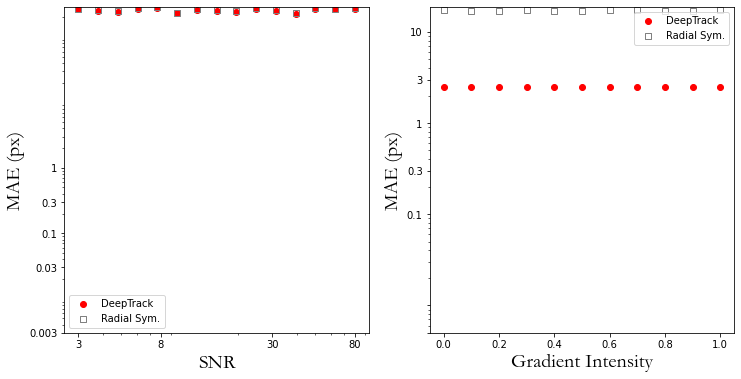

In [ ]:
#notest
with open('snr_results_2.pkl','rb') as f:
    Md_snr,Ms_snr = pickle.load(f)

with open('gi_results_2.pkl','rb') as f:
    Md_gi,Ms_gi = pickle.load(f)

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(x=np.array(Md_snr)[:,0],y=np.array(Md_snr)[:,1],label='DeepTrack',marker='o',c='r')
ax[0].scatter(x=np.array(Ms_snr)[:,0],y=np.array(Ms_snr)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xticks([3,8,30,80])
ax[0].set_xticklabels([3,8,30,80])
ax[0].set_yticks([0.003,0.03,0.1,0.3,1])
ax[0].set_yticklabels([0.003,0.03,0.1,0.3,1])
ax[0].set_xlabel('SNR', fontsize=20, fontfamily='Garamond')
ax[0].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[0].legend()

# Gradient Intensity Plot
ax[1].scatter(x=np.array(Md_gi)[:,0],y=np.array(Md_gi)[:,1],label='DeepTrack',marker='o',c='r')
ax[1].scatter(x=np.array(Ms_gi)[:,0],y=np.array(Ms_gi)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[1].set_yscale('log')
ax[1].set_yticks([0.005,0.01,0.1,0.3,1,3,10])
ax[1].set_yticklabels(['','',0.1,0.3,1,3,10])
ax[1].set_xlabel('Gradient Intensity', fontsize=20,fontfamily='Garamond')
ax[1].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[1].legend()

In [ ]:
#notest
# take the predicted positions and compare to symtry method
video_file_name = '../../DeepTrack 1.0/DeepTrack - Example 2 - Optically Trapped Particle Bad.mp4'

estimators = {
        'deeptrack':lambda image: learner.predict(npimg2tensor(image))[1].numpy(),
        'symmetry':lambda image: np.array(radialcenter(image)[:3],dtype=np.float32),
    }

predicted_positions = track_single_particle(
    video_file_name, 
    estimators,use_cv2=False)

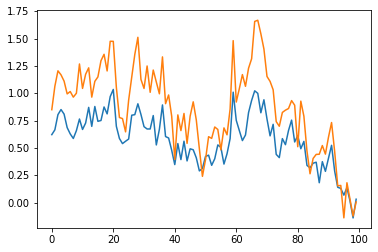

In [ ]:
#notest
plt.plot(predicted_positions['deeptrack'][:,1])
plt.plot(predicted_positions['symmetry'][:,1])
